Preliminary analysis performed on a few flies (305 - 317) u56(Gcamp6f) X R22H05 to test modifications to the stimulus protocol - 6 stim conditions (clkwise/cclkwise yaw,translate forward, backward up and down. 10 reps for each direction. The first 5 flies were very young < 24 hrs old. the second 4 were between 24-48 hrs old and produced more consistent behavioral results.

The remaining analyis was performed on flies 1 day of age. 4 cohorts of flies expressing Gcamp6f in flight muscles.

In [1]:
%pylab

Using matplotlib backend: WXAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import flylib
import db_access as dba
fly_db = dba.get_db()

In [3]:
GMR22H05_list = [308,309,310,311,312,313,314,315,316,317,327,328] #range(317,326)
GMR22H05_swarm = flylib.Squadron(fly_db,GMR22H05_list)
GMR39E01_list = [318,319,320,321,322,323,324,325,329,330,331,332,333,334,335,336]
GMR39E01_swarm = flylib.Squadron(fly_db,GMR39E01_list)
GMR31E10_list = [337,338,339,340,341,342,343,344,345,346,347,348]
GMR31E10_swarm = flylib.Squadron(fly_db,GMR31E10_list)
GMR29E05_list = [349,350,351,352,353,354,355,356,357,358,359,360]
GMR29E05_swarm = flylib.Squadron(fly_db,GMR29E05_list)

GMR22H05_GFP_list = [370,371,372,373,380,381,382,383]
GMR22H05_GFP_swarm = flylib.Squadron(fly_db,GMR22H05_GFP_list)

GMR31E10_GFP_list = [361,362,363,364,365,384,385,386]
GMR31E10_GFP_swarm = flylib.Squadron(fly_db,GMR31E10_GFP_list)

GMR29E05_GFP_list = [366,367,368,369,376,377,378,379]
GMR29E05_GFP_swarm = flylib.Squadron(fly_db,GMR29E05_GFP_list)

In [4]:
encode = {'regressive':1,'descending':2,'progressive':3,'ascending':4,'flow_right':6,'flow_left':5}
decode = dict()
for key,value in zip(encode.keys(),encode.values()):
    decode[value] = key

In [5]:
def get_cond(fly,trial):
    """extact the experimental condition from a trial"""
    expmnt = fly.experiments.values()[0]
    sigs = expmnt.exp_record['tiff_data']['axon_framebase']
    cond_data = np.array(sigs['StimCond'])[trial]
    val = np.around(np.mean(cond_data[cond_data>0.5]))
    if isnan(val):
        raise ValueError
    return val

In [6]:
swarms = {'GMR22H05':GMR22H05_swarm,
          'GMR39E01':GMR39E01_swarm,
          'GMR31E10':GMR31E10_swarm,
          'GMR29E05':GMR29E05_swarm,
          'GMR22H05_GFP':GMR22H05_GFP_swarm,
          'GMR31E10_GFP':GMR31E10_GFP_swarm,
          'GMR29E05_GFP':GMR29E05_GFP_swarm
         }

## Behavioral analysis

In [7]:
def get_signal_mtrxs(swarm):
    """construct evenly sampled data matrix from a set of trials"""
    from scipy.interpolate import griddata
    signal_mtrxs = {'fly_num':[],
                    'trial_cond':[],
                    'wb_period':[],
                    'wb_frequency':[],
                    'strobe_time':[],
                    'Ph0':[],'Ph1':[],'Ph2':[],'Ph3':[],
                    'StimCond':[]}
    for fly in swarm.flies:
        #print fly.fly_num
        expmnt = fly.experiments.values()[0]
        sigs = expmnt.exp_record['tiff_data']['axon_framebase']
        trials = flylib.idx_by_thresh(np.array(sigs['StimCond']),-0.0)
        for trial in trials:
            try:
                cond = get_cond(fly,trial)
                times = np.array(sigs['times'])[trial] - sigs['times'][trial[0]]
                xi = np.linspace(0,23,1150)
                signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['trial_cond'].append(cond)
                for skey in ['wb_period','wb_frequency','strobe_time','Ph0','Ph1','Ph2','Ph3','StimCond']:
                    resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                    signal_mtrxs[skey].append(resamp)
            except ValueError:
                print 'ValueError'
    for skey in signal_mtrxs.keys():
        signal_mtrxs[skey] = np.array(signal_mtrxs[skey])
    signal_mtrxs['LmR'] = signal_mtrxs['Ph0'] - signal_mtrxs['Ph1']
    signal_mtrxs['LpR'] = signal_mtrxs['Ph0'] + signal_mtrxs['Ph1']
    d_matrix = array([signal_mtrxs['fly_num'] == fly.fly_num for fly in swarm.flies])
    return signal_mtrxs,d_matrix,xi

In [8]:
def get_inclusion(signal_mtrxs,
                  condition,
                  min_wbfreq = 180,
                  trial_prop = 0.9):
    """ get the trial inclusion vector for a given condition"""
    trial_len = shape(signal_mtrxs['wb_frequency'])[1]
    #wbfreq was greater than min_wbfreq for > trial_prop of the trial
    criterion = sum(signal_mtrxs['wb_frequency']>min_wbfreq,axis = 1)>(trial_len*trial_prop)
    criterion *= sum(~isfinite(signal_mtrxs['wb_frequency']),axis = 1) == 0
    #criterion *= ~(sum(signal_mtrxs['wb_frequency']>250,axis = 1) > 0)
    #print ~(sum(signal_mtrxs['wb_frequency']>250,axis = 1) > 0)
    #encode = {'regressive':1,'descending':2,'progressive':3,'ascending':4,'flow_right':5,'flow_left':6}
    include = signal_mtrxs['trial_cond'] == encode[condition]
    include *= criterion
    return include

def calc_summary_stats(signal_mtrxs,
                       design_mtrx,
                       signal,
                       include,
                       decode = None,
                       min_num_trials = 5):
    """ return the summary stats - within cell --fly-- means, as well as grand mean 
    and std. Pass a dictionary of signal matrixs 'signal_mtrxs', the experimental
    design matrx 'design_mtrx', the signal of interest, and a 
    binary vector indicating the included trials. Note that the independent 'cells' are
    specified by the design matrix and does not necessarily need to be single fly"""
    data = signal_mtrxs[signal]*include.T[:,np.newaxis]
    trials_in_flies = dot(design_mtrx.astype(float),include.astype(float))[:,newaxis]
    sum_flies = dot(design_mtrx,nan_to_num(data))
    include_flies = squeeze(trials_in_flies > min_num_trials)
    #individual fly means
    cell_means = sum_flies[include_flies]/trials_in_flies[include_flies]
    #mean across group
    grand_mean = mean(decode(cell_means),axis = 0)
    #std across group
    grand_std = std(decode(cell_means),axis = 0)
    return {'cell_means':cell_means,'grand_mean':grand_mean,'grand_std':grand_std}

In [9]:
def plot_fly_behavior(signal_mtrxs,design_mtrx,xi):
    condition_plotdata = {'flow_right':   {'column':0,'color':'r'},
                      'flow_left':  {'column':0,'color':'b'},
                      'progressive':  {'column':1,'color':'r'},
                      'regressive': {'column':1,'color':'b'},
                      'ascending':   {'column':2,'color':'r'},
                      'descending': {'column':2,'color':'b'}}

    signal_plotdata = {'Ph0':          {'row':0,'decode': lambda x: rad2deg(x/5), 'ybound':(0,90),    'label':'Lwing'},
                       'Ph1':          {'row':1,'decode': lambda x: rad2deg(x/5), 'ybound':(0,90),    'label':'Rwing'},
                       'LmR':          {'row':2,'decode': lambda x: rad2deg(x/5), 'ybound':(-60,60),  'label':'L-R'  },
                       'LpR':          {'row':3,'decode': lambda x: rad2deg(x/5), 'ybound':(40,140),  'label':'L+R'  },
                       'wb_frequency': {'row':4,'decode': lambda x: x,            'ybound':(180,240), 'label':'freq' }}

    condition_list = ['flow_right','flow_left','progressive','regressive','ascending','descending']
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(5, 3)

    for skey in signal_plotdata.keys():
        for condition in condition_plotdata.keys():
            ax = plt.subplot(gs[signal_plotdata[skey]['row'], 
                                condition_plotdata[condition]['column']])
            axvspan(10, 13, ymin=0, ymax=1, alpha = 0.1,facecolor = 'k',edgecolor = (0,0,0,0))
            include = get_inclusion(signal_mtrxs,condition)
            summary_data = calc_summary_stats(signal_mtrxs,
                                              design_mtrx,
                                              skey,
                                              include,
                                              decode = signal_plotdata[skey]['decode'])
            grand_mean = summary_data['grand_mean']
            grand_std = summary_data['grand_std']
            lns = plot(xi,grand_mean,alpha = 1.0,color = condition_plotdata[condition]['color'])
            lns = fill_between(xi,
                               grand_mean+grand_std,
                               grand_mean-grand_std,
                               alpha = 0.3,color = condition_plotdata[condition]['color'],lw = 0.1)
            n = shape(summary_data['cell_means'])[0]
            ax.set_ybound(signal_plotdata[skey]['ybound'])
            
            if condition_plotdata[condition]['column'] >0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(signal_plotdata[skey]['label'])
            if signal_plotdata[skey]['row'] < 4:
                ax.set_xticklabels([])
            if signal_plotdata[skey]['row'] == 0:
                if condition_plotdata[condition]['color'] == 'r':
                    ax.annotate('%s n=%s'%(condition,n),xy = (0.10,0.8),xycoords='axes fraction',color = 'r')
                else:
                    ax.annotate('%s n=%s'%(condition,n),xy = (0.10,0.65),xycoords='axes fraction',color = 'b')
            
            ax.set_xbound(0,23)

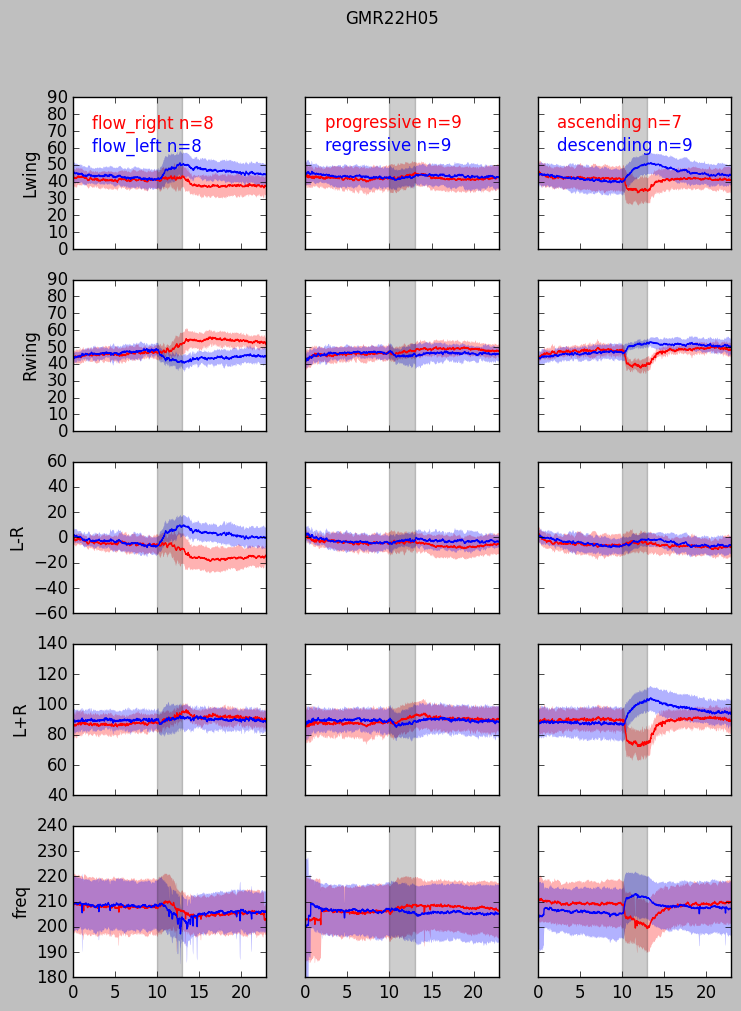

In [10]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(GMR22H05_swarm))
gcf().suptitle('GMR22H05')
savefig('GMR22H05_behavior.pdf')
display(gcf());close()

/Users/theodorelindsay/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:445: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/theodorelindsay/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/theodorelindsay/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
-c:8: RuntimeWarning: invalid value encountered in greater


ValueError


-c:28: RuntimeWarning: invalid value encountered in multiply


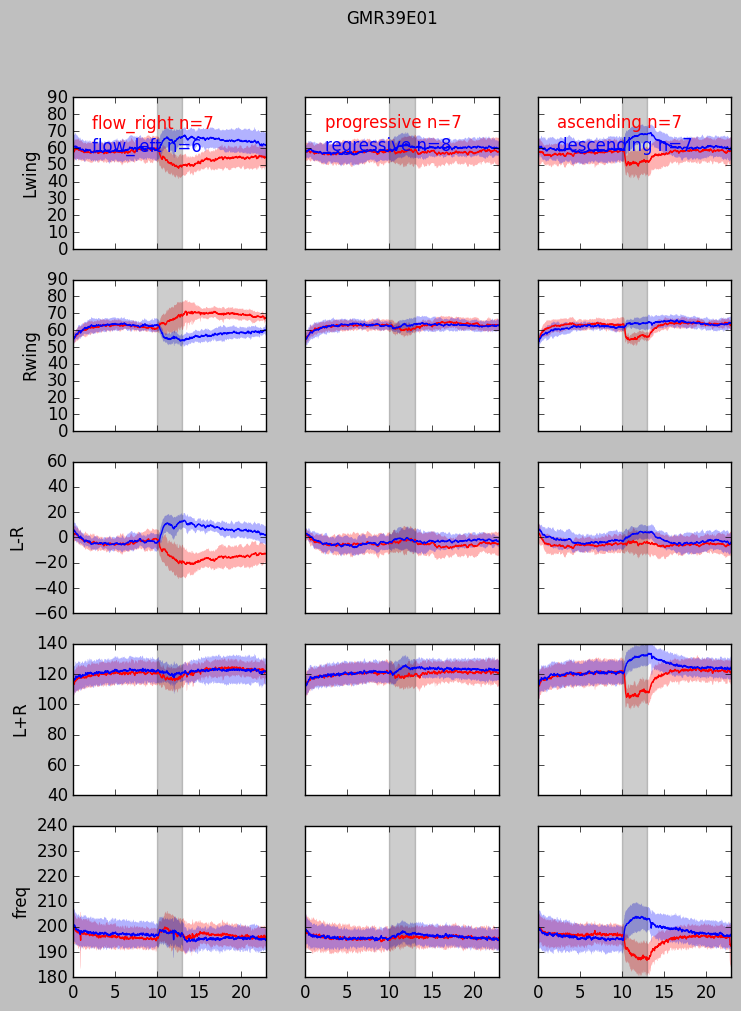

In [11]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(GMR39E01_swarm))
gcf().suptitle('GMR39E01')
savefig('GMR39E01_behavior.pdf')
display(gcf());close()

ValueError


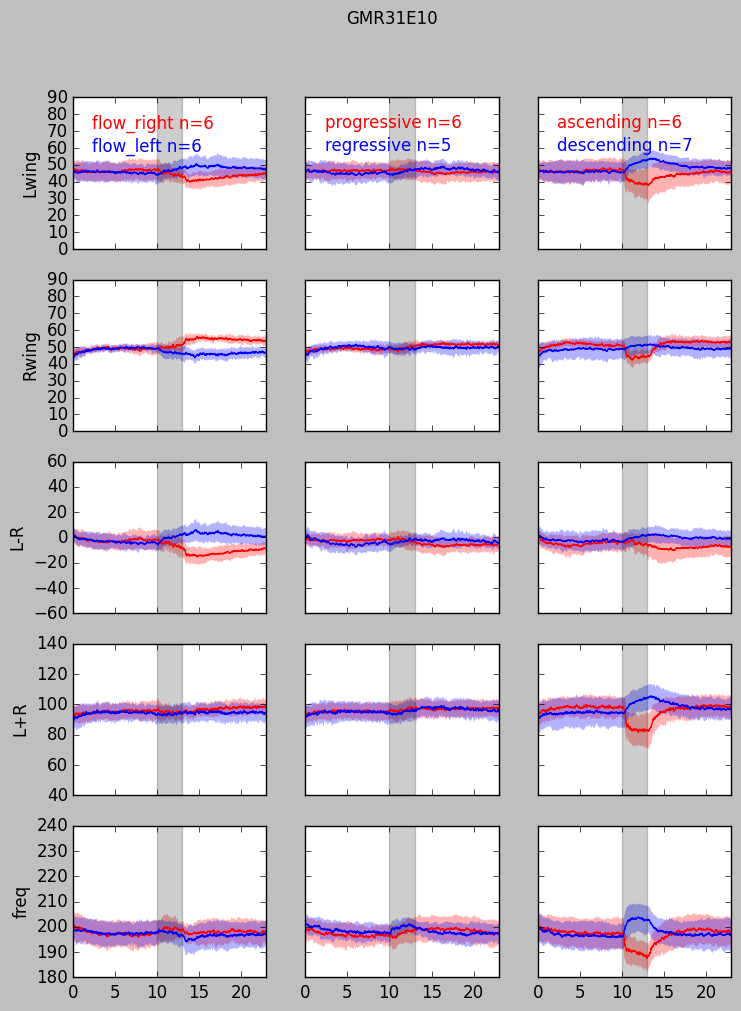

In [12]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(GMR31E10_swarm))
gcf().suptitle('GMR31E10')
savefig('GMR31E10_behavior.pdf')
display(gcf());close()

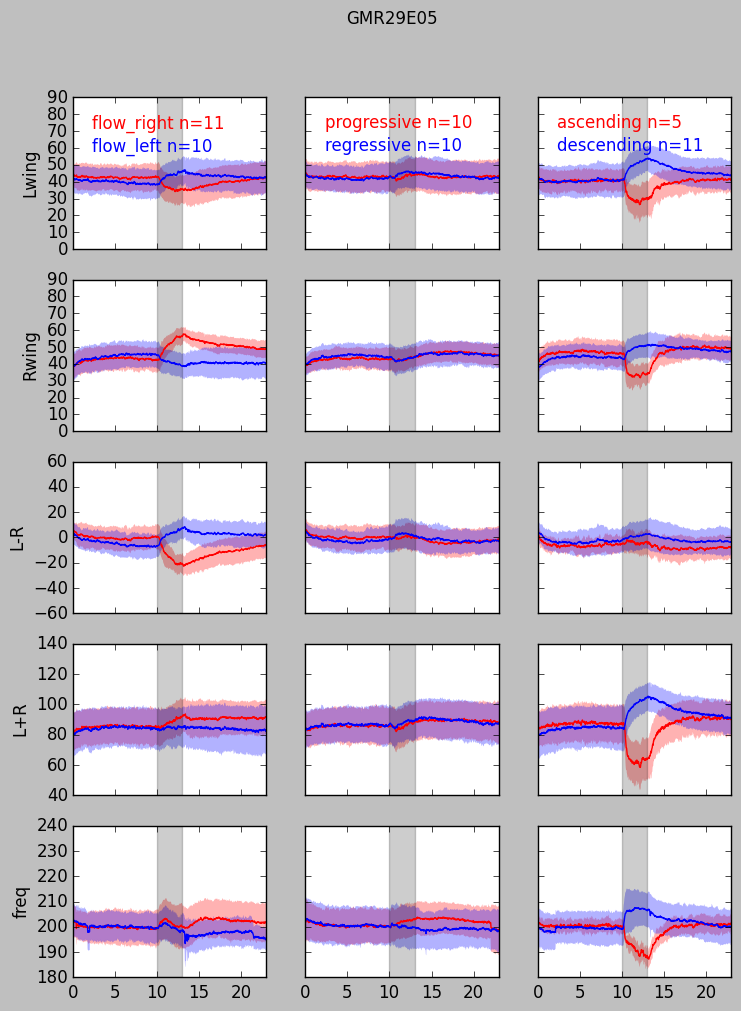

In [13]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(GMR29E05_swarm))
gcf().suptitle('GMR29E05')
savefig('GMR29E05_behavior.pdf')
display(gcf());close()

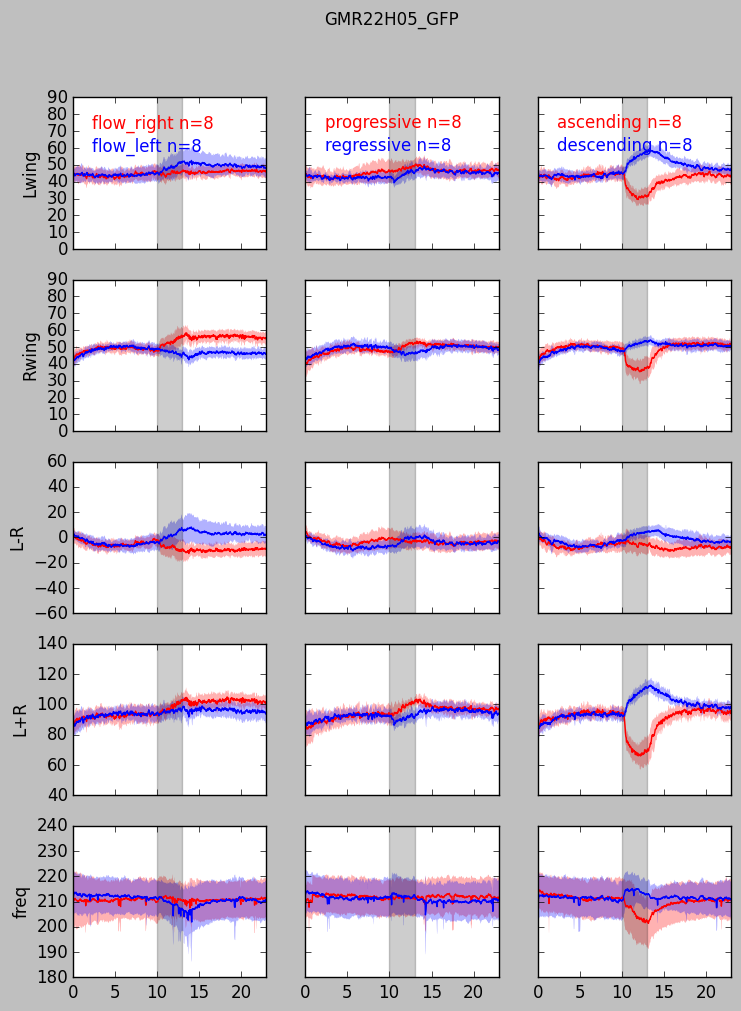

In [14]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(GMR22H05_GFP_swarm))
gcf().suptitle('GMR22H05_GFP')
savefig('GMR22H05_GFP_behavior.pdf')
display(gcf());close()

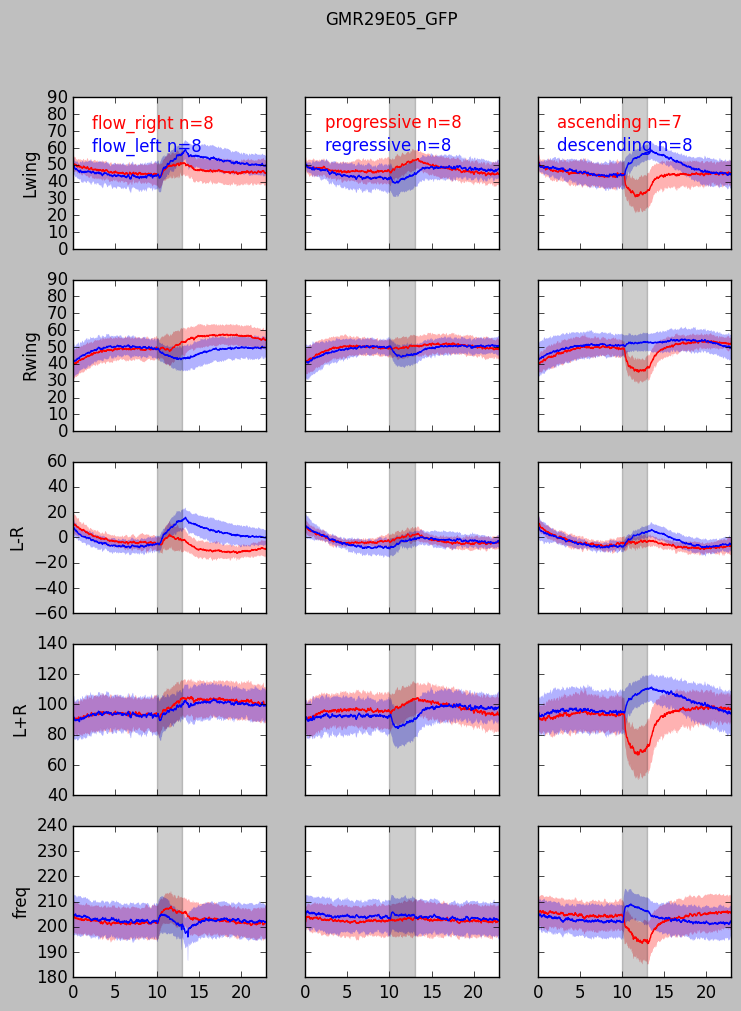

In [15]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(GMR29E05_GFP_swarm))
gcf().suptitle('GMR29E05_GFP')
savefig('GMR29E05_GFP_behavior.pdf')
display(gcf());close()

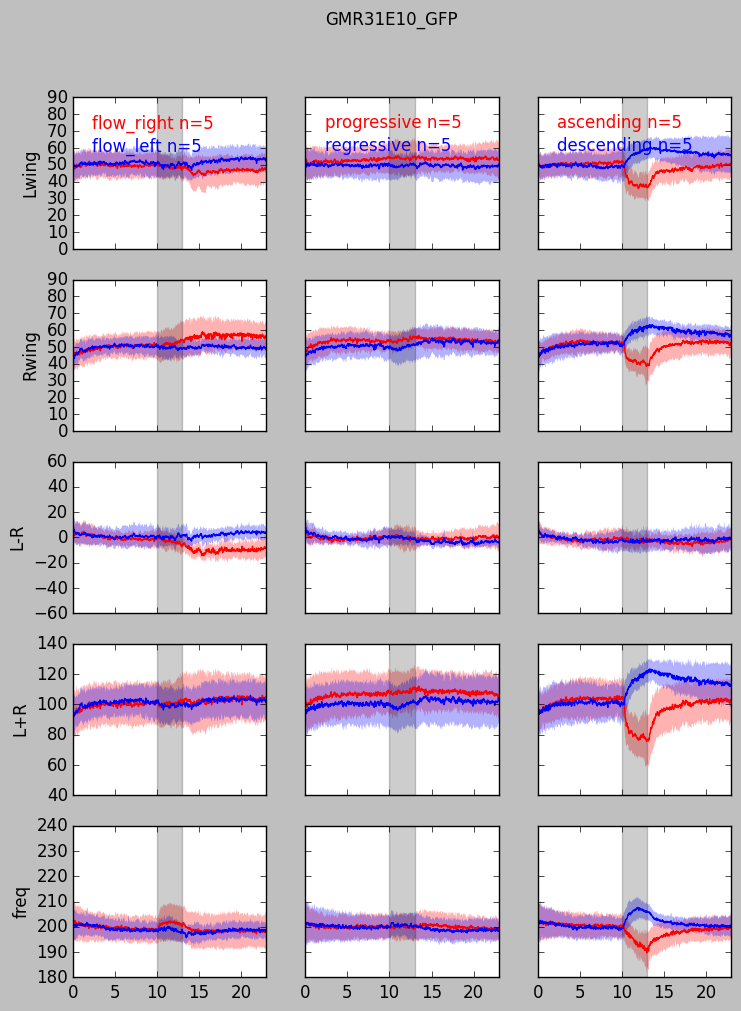

In [16]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(GMR31E10_GFP_swarm))
gcf().suptitle('GMR31E10_GFP')
savefig('GMR31E10_GFP_behavior.pdf')
display(gcf());close()

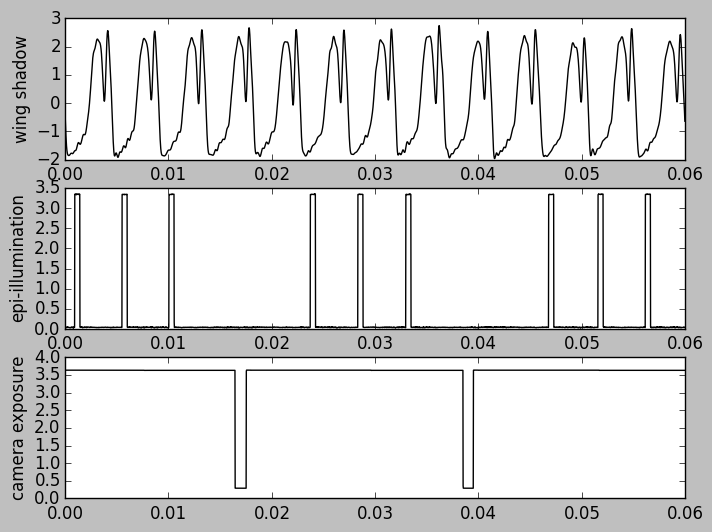

In [13]:
#plot the timing diagram for the led pulse protocol
fly = GMR22H05_swarm.flies[-1]
expmnt = fly.experiments.values()[0]
sigs = expmnt.exp_record['axon_data']
rng = slice(3004000,3007000)
tms = sigs['times'][rng]
tms -= tms[0]
subplot(3,1,1)
plot(tms,sigs['RightWing'][rng],color = 'k');gca().set_ylabel('wing shadow')
gca().set_ybound(-2,3)
subplot(3,1,2,sharex = gca())
plot(tms,sigs['Photostim'][rng],color = 'k');gca().set_ylabel('epi-illumination')
subplot(3,1,3,sharex = gca())
plot(tms,sigs['CamSync'][rng],color = 'k');gca().set_ylabel('camera exposure')
display(gcf());close()

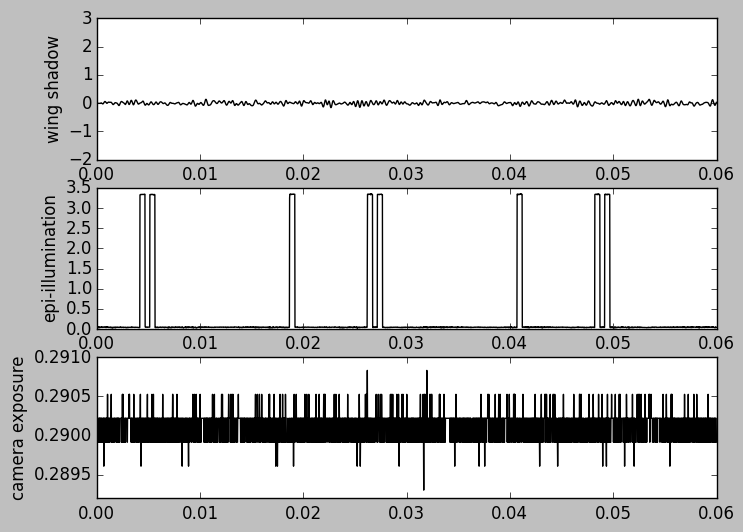

In [14]:
#plot the timing diagram for the led pulse protocol
fly = GMR22H05_swarm.flies[-1]
expmnt = fly.experiments.values()[0]
sigs = expmnt.exp_record['axon_data']
rng = slice(0,3000)
tms = sigs['times'][rng]
tms -= tms[0]
subplot(3,1,1)
plot(tms,sigs['RightWing'][rng],color = 'k');gca().set_ylabel('wing shadow')
gca().set_ybound(-2,3)
subplot(3,1,2,sharex = gca())
plot(tms,sigs['Photostim'][rng],color = 'k');gca().set_ylabel('epi-illumination')
subplot(3,1,3,sharex = gca())
plot(tms,sigs['CamSync'][rng],color = 'k');gca().set_ylabel('camera exposure')
display(gcf());close()

## Calculate image stats for each fly

In [5]:
#code to calculate the summary stats for the data
%pylab
import flylib
import db_access as dba
fly_db = dba.get_db()
test_group = range(361,387) #range(317,326)

swarm = flylib.Squadron(fly_db,test_group)#GMR29E05_swarm
def wing_correlations(sig,imgs,fly = None):
    #calculate some summary images including the correlation image
    mean_img = mean(imgs,axis=0)
    zeroed_img = imgs - mean_img
    max_img = np.max(imgs,axis = 0)
    norm_img = numpy.linalg.norm(zeroed_img,axis = 0)
    norm_sig = numpy.linalg.norm(sig-np.mean(sig))
    dot_img = sum(zeroed_img*(sig[:,newaxis,newaxis]-np.mean(sig)),axis = 0)
    corr_img = dot_img/(norm_img*norm_sig)
    return {'mean_img':mean_img,
        'max_img':max_img,
        'norm_img':norm_img,
        'dot_img':dot_img,
        'corr_img':corr_img}

def imgs_stats(fly = None):
    #get signals from fly
    rwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph1'])
    lwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph0'])
    wbf = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['wb_frequency'])
    StimCond = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['StimCond'])
    images = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
    mask = ((StimCond<0) & (wbf >150))[:shape(images)[0]]
    #print sum(mask)
    return {'lwing':wing_correlations(lwing[mask],images[mask]),
            'rwing':wing_correlations(rwing[mask],images[mask]),
            'freq':wing_correlations(wbf[mask],images[mask])}

import cPickle
for fly in swarm.flies:
    #print fly.fly_num
    stats = imgs_stats(fly = fly)
    fi = open(fly.fly_path + 'img_stats.cpkl','wb')
    cPickle.dump(stats,fi)
    fi.close()
    
for fly in swarm.flies:
    fi = open(fly.fly_path + 'img_stats.cpkl','rb')
    stats = cPickle.load(fi)
    fi.close()
    figure()
    imshow(stats['rwing']['corr_img'].reshape(130,174),cmap = cm.gray)

`%matplotlib` prevents importing * from pylab and numpy
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: invalid value encountered in subtract
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in subtract
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


Using matplotlib backend: WXAgg
Populating the interactive namespace from numpy and matplotlib


/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [28]:
def wing_correlations_df(sig,imgs,fly = None):
    #calculate some summary images including the correlation image
    include = isfinite(sig)
    sig = sig[include]
    imgs = imgs[include]
    #now calculate stats
    mean_img = mean(imgs,axis=0)
    zeroed_img = imgs - mean_img
    
    max_img = np.max(imgs,axis = 0)
    norm_img = numpy.linalg.norm(zeroed_img,axis = 0)
    norm_sig = numpy.linalg.norm(sig-np.mean(sig))
    dot_img = sum(zeroed_img*(sig[:,newaxis,newaxis]-np.mean(sig)),axis = 0)
    corr_img = dot_img/(norm_img*norm_sig)
    return {'mean_img':mean_img,
        'max_img':max_img,
        'norm_img':norm_img,
        'dot_img':dot_img,
        'corr_img':corr_img}

def imgs_stats_df(fly = None):
    #get signals from fly
    rwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph1'])
    lwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph0'])
    wbf = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['wb_frequency'])
    StimCond = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['StimCond'])
    images = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
    mask = ((StimCond<0) & (wbf >150))[:shape(images)[0]]
    #load baseline data
    fi = open(fly.fly_path + 'epoch_data.cpkl')
    import cPickle
    baseline_range = cPickle.load(fi)['baseline_F']
    fi.close()
    F = np.mean(images[baseline_range],axis = 0)
    #calculate dF/F
    imgs = (images[mask]-F)/F
    #print sum(mask)
    return {'lwing':wing_correlations_df(lwing[mask],imgs),
            'rwing':wing_correlations_df(rwing[mask],imgs),
            'freq':wing_correlations_df(wbf[mask],imgs)}

swarm_list = [GMR22H05_GFP_swarm,GMR31E10_GFP_swarm,GMR29E05_GFP_swarm]

import cPickle
for swarm in swarm_list:
    for fly in swarm.flies:
        #print fly.fly_num
        try:
            stats = imgs_stats_df(fly = fly)
            fi = open(fly.fly_path + 'img_stats_df.cpkl','wb')
            cPickle.dump(stats,fi)
            fi.close()
        except IOError:
            print fly.fly_num

    for fly in swarm.flies:
        try:
            fi = open(fly.fly_path + 'img_stats_df.cpkl','rb')
            stats = cPickle.load(fi)
            fi.close()
            figure()
            imshow(stats['rwing']['corr_img'].reshape(130,174),cmap = cm.gray)
        except IOError:
            print fly.fly_num

/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: divide by zero encountered in divide
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in divide
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in subtract
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [71]:
fly.fly_num

308

In [14]:
[fly.fly_num for fly in swarm.flies[-6:]]

[314, 315, 316, 317, 327, 328]

## Load the reference frame data and make correlation plots

In [48]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_image(fly,img,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_swarm_summary(swarm):
    import cPickle
    corr_list = list()
    norm_list = list()
    freq_list = list()
    for fly in swarm.flies:
        try:
            f = open(fly.fly_path + 'img_stats_df.cpkl','rb')
            stats = cPickle.load(f)
            f.close()
            corr_list.append([fly,stats['rwing']['corr_img'].reshape(130,174)])
            norm_list.append([fly,stats['rwing']['norm_img'].reshape(130,174)])
            freq_list.append([fly,stats['freq']['corr_img'].reshape(130,174)])
        except IOError:
            print fly.fly_num
    warped_imgs = list()
    for fly,img in norm_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_norm = mean(dstack(warped_imgs),axis = 2)
    
    warped_imgs = list()
    for fly,img in corr_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_corr = mean(dstack(warped_imgs),axis = 2)
        
    warped_imgs = list()
    for fly,img in freq_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_freq_corr = mean(dstack(warped_imgs),axis = 2)
    
    return(group_norm,group_corr,group_freq_corr)
    
def plot_swarm_corr(swarm,contour_kwargs = None,
                    line_name = None,
                    plot_pans = None,vmin = -1.0,vmax = 1.0,
                   xbounds = None,ybounds = None,cmap = cm.gray):
    line_label = line_name
    axes(plot_pans[0])
    import os
    filelist = os.listdir('./')
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    antibody_file = filter(lambda x: (line_name in x) and ('(RGB)' in x),filelist)[0]
    print antibody_file
    import tifffile
    tfile = tifffile.TiffFile(antibody_file)
    antibody_image = tfile.asarray()
    imshow(antibody_image)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_ylabel(line_label)
    
    group_norm,group_corr,group_freq_corr = get_swarm_summary(swarm)

    axes(plot_pans[1])
    imshow(group_norm,cmap = cmap,vmin = 0,vmax = 200)
    #subplot(1,2,1)
    #plot_args = {'plot_frame':False,'contour_kwargs':{'edgecolor':'y','alpha':0.5,'facecolor':'none'}}
    plot_args = {'plot_frame':False,'contour_kwargs':contour_kwargs}
    confocal_view.plot(confocal_model.frame,plot_args = plot_args)
    gca().set_xbound(0,1000)
    gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    #gca().set_title('std image')
    
    #subplot(1,2,2)
    axes(plot_pans[2])
    imshow(group_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    plot_args = {'plot_frame':False,'contour_kwargs':contour_kwargs}
    confocal_view.plot(confocal_model.frame,plot_args = plot_args)
    gca().set_xbound(0,1000)
    gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)

    axes(plot_pans[3])
    imshow(group_freq_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    plot_args = {'plot_frame':False,'contour_kwargs':contour_kwargs}
    confocal_view.plot(confocal_model.frame,plot_args = plot_args)
    gca().set_xbound(0,1000)
    gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    #gca().set_title('correlation image')
    
    #suptitle(line_name)
    
def get_kwargs(line_name):
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    contour_kwargs = dict()
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    for key in line_database[line_name].keys():
        if 'DVM' in key:
            contour_kwargs['DVM1'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM2'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM3'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
        else:
            contour_kwargs[key] = {'linewidth':line_database[line_name][key]/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
    return contour_kwargs

In [53]:
from matplotlib import gridspec

vmin = -0.5
vmax = 0.5
xmin = 60
xmax = 750
xbounds = (xmin,xmax)
ymin = 325
ymax = 900
ybounds = (ymin,ymax)

gs = gridspec.GridSpec(7, 4)

for i,line_name in enumerate(sorted(swarms.keys())):
    plot_pans = [subplot(gs[i,row]) for row in range(4)]
    if i == 0:
        axes(plot_pans[0])
        gca().set_title('antibody staining')
        axes(plot_pans[1])
        gca().set_title('standard deviation')
        axes(plot_pans[2])
        gca().set_title('right wing correlation')
        
    contour_kwargs = get_kwargs(line_name = line_name)
    plot_swarm_corr(swarms[line_name],
                    contour_kwargs,
                    line_name = line_name,
                    plot_pans = plot_pans,
                    vmin = vmin,vmax = vmax,
                    xbounds = xbounds,ybounds = ybounds,
                    cmap = cm.gray)
    #savefig(line_name + '_corr' + '.pdf')
    #close()
savefig('correlations.pdf')

MAX_22H05_03.tif (RGB).tif
MAX_22H05_03.tif (RGB).tif
MAX_29E05_01.tif (RGB).tif
MAX_29E05_01.tif (RGB).tif
MAX_31E10_02.tif (RGB).tif
MAX_31E10_02.tif (RGB).tif
MAX_39E01_01.tif (RGB).tif


In [82]:
ax = gca()

In [7]:
len(swarms.keys())

7

In [67]:
stats_file.close()

In [68]:
stats.keys()

['lwing', 'rwing', 'freq']

In [69]:
freq = stats['freq']['corr_img']

In [70]:
imshow(freq,cmap = cm.gray)

In [21]:
### a block to view a max confocal image
import os
filelist = os.listdir('./')
antibody_file = filter(lambda x: ('22H05' in x) and ('(RGB)' in x),filelist)[0]
import tifffile
tfile = tifffile.TiffFile(antibody_file)
antibody_image = tfile.asarray()
imshow(antibody_image)

## Calculation of dF/F stats

In [5]:
#GMR22H05_swarm 
#GMR39E01_swarm
#GMR31E10_swarm
#GMR29E05_swarm

#GMR22H05_GFP_swarm = flylib.Squadron(fly_db,GMR22H05_GFP_list)

#GMR31E10_GFP_swarm = flylib.Squadron(fly_db,GMR31E10_GFP_list)

#GMR29E05_GFP_swarm = flylib.Squadron(fly_db,GMR29E05_GFP_list)

In [7]:
def get_data(fly):
    #this function interpolates a movie for each trial and returns the data as a dictionary
    expmnt = fly.experiments.values()[0]
    sigs = expmnt.exp_record['tiff_data']['axon_framebase']
    trials = flylib.idx_by_thresh(np.array(sigs['StimCond']),-0.0)
    imgs = expmnt.exp_record['tiff_data']['images']
    def get_resamp_imgs(cond):
        cond_idxs = [t for t in trials if get_cond(fly,t) == encode[cond]]
        img_sequences = [np.array(imgs[t[0]:t[-1]]) for t in cond_idxs]
        img_times = [np.array(sigs['times'][t[0]:t[-1]])-sigs['times'][t[0]] for t in cond_idxs]
        scond_sequences =  [np.array(sigs['StimCond'][t[0]:t[-1]]) for t in cond_idxs]
        resampled_img_sequences = list()
        resampled_scond_sequences = list()
        from scipy.interpolate import interp1d
        for tms,seq,scond in zip(img_times,img_sequences,scond_sequences):
            fx = interp1d(tms,seq,axis = 0)
            sc = interp1d(tms,scond,axis =0)
            resample_times = np.arange(0,23,0.03)
            resampled_img_sequences.append(fx(resample_times))
            resampled_scond_sequences.append(sc(resample_times))
        return resampled_img_sequences,resampled_scond_sequences
    movie_dict = dict()
    #scond_dict = dict()
    for cond in encode.keys():
        print cond
        resampled_img_sequences,resampled_scond_sequences = get_resamp_imgs(cond)
        movie_dict[cond] = np.mean(resampled_img_sequences,axis = 0)
        #scond_dict[cond] = np.mean(resampled_scond_sequences,axis = 0)
    return movie_dict

In [17]:
def get_data_DF_F(fly):
    #this function interpolates a movie for each trial and returns the data as a dictionary
    expmnt = fly.experiments.values()[0]
    sigs = expmnt.exp_record['tiff_data']['axon_framebase']
    trials = flylib.idx_by_thresh(np.array(sigs['StimCond']),-0.0)
    imgs = expmnt.exp_record['tiff_data']['images']
    f = open(fly.fly_path + 'epoch_data.cpkl')
    import cPickle
    baseline_range = cPickle.load(f)['baseline_F']
    f.close()
    F = np.mean(imgs[baseline_range],axis = 0)
    def get_resamp_imgs(cond):
        cond_idxs = [t for t in trials if get_cond(fly,t) == encode[cond]]
        
        img_sequences = [np.array(imgs[t[0]:t[-1]]) for t in cond_idxs]
        img_times = [np.array(sigs['times'][t[0]:t[-1]])-sigs['times'][t[0]] for t in cond_idxs]
        scond_sequences =  [np.array(sigs['StimCond'][t[0]:t[-1]]) for t in cond_idxs]
        rwing_sequences =  [np.array(sigs['Ph1'][t[0]:t[-1]]) for t in cond_idxs]
        freq_sequences = [np.array(sigs['wb_frequency'][t[0]:t[-1]]) for t in cond_idxs]
        
        resampled_img_sequences = list()
        resampled_scond_sequences = list()
        resampled_rwing_sequences = list()
        resampled_freq_sequences = list()
        
        from scipy.interpolate import interp1d
        for tms,seq,scond,rwing,freq in zip(img_times,
                                       img_sequences,
                                       scond_sequences,
                                       rwing_sequences,
                                       freq_sequences):
            fx = interp1d(tms,seq,axis = 0)
            sx = interp1d(tms,scond,axis =0)
            rx = interp1d(tms,rwing,axis =0)
            qx = interp1d(tms,freq,axis = 0)
            resample_times = np.arange(0,23,0.03)
            
            img_seq = (fx(resample_times)-F)/F
            img_seq[~isfinite(img_seq)] = 0
            
            resampled_img_sequences.append(img_seq)
            resampled_scond_sequences.append(sx(resample_times))
            resampled_rwing_sequences.append(rx(resample_times))
            resampled_freq_sequences.append(qx(resample_times))
        return resampled_img_sequences,resampled_scond_sequences,resampled_rwing_sequences,resampled_freq_sequences
    
    movie_dict = dict()
    scond_dict = dict()
    rwing_dict = dict()
    freq_dict = dict()
    
    for cond in encode.keys():
        resampled_img_sequences,resampled_scond_sequences,resampled_rwing_sequences,resampled_freq_sequences = get_resamp_imgs(cond)
        movie_dict[cond] = np.mean(resampled_img_sequences,axis = 0)
        scond_dict[cond] = np.mean(resampled_scond_sequences,axis = 0)
        rwing_dict[cond] = np.mean(resampled_rwing_sequences,axis = 0)
        freq_dict[cond] = np.mean(resampled_freq_sequences,axis = 0)
    return movie_dict,scond_dict,rwing_dict,freq_dict

In [22]:
swarms = [GMR22H05_swarm,
         GMR39E01_swarm,
         GMR31E10_swarm,
         GMR29E05_swarm,
         GMR22H05_GFP_swarm,
         GMR31E10_GFP_swarm,
         GMR29E05_GFP_swarm]

In [27]:
import h5py
#loop over a swarm and save the interpolated movie data
for swarm in swarms:
    for fly in swarm.flies:
        import cPickle
        try:
            movie_data,cond_data,wing_data,freq_data = get_data_DF_F(fly)
            fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','a')

            movie_group = fi.create_group('movie_data')
            for key in movie_data:
                movie_group[key] = movie_data[key]

            cond_group = fi.create_group('cond_data')
            for key in cond_data:
                cond_group[key] = cond_data[key]

            wing_group = fi.create_group('wing_data')
            for key in wing_data:
                wing_group[key] = wing_data[key]

            freq_group = fi.create_group('freq_data')
            for key in freq_data:
                freq_group[key] = freq_data[key]

            fi.flush()
            fi.close()
            print fly.fly_num
            #f = open(fly.fly_path + 'trial_data_dF_F.cpkl','wb')
            #cPickle.dump(data,f)
            #f.close()
        except (IOError,ValueError):
            print 'error'

308
309
310
311
312
error
314
315
316
317
327
328
318
319
320
321
322
323
324
325
329
330
331
332

/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: divide by zero encountered in divide
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:466: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]



333
error
335
336
error
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
370
371
372
373
380
381
382
383
361
362
363
364
365
384
385
386
366
367
368
369
376
377
378
379


/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
#import os
#for swarm in swarms:
#    for fly in swarm.flies:
#        try:
#            os.remove(fly.fly_path + 'trial_movies.hdf5')
#        except OSError:
#            print fly.fly_num

308
309
310
311
312
313
314
315
316
317
327
328
318
319
320
321
322
323
324
325
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
370
371
372
373
380
381
382
383
361
362
363
364
365
384
385
386
366
367
368
369
376
377
378
379


In [28]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_movie(fly,imgs,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    output_data = zeros((shape(imgs)[0],output_shape[0],output_shape[1]))
    for i,img in enumerate(imgs):
        X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
        output_data[i,:,:]= X_warped
    return output_data

In [33]:
def accumulate_trial_movie(fly,winput=None,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    img_data = np.array(fi['movie_data'][trial_key])
    fi.close()
    wmovie = warp_fly_movie(fly,img_data,s=0.25)
    if winput == None:
        return wmovie
    else:
        wmovie += winput
        return wmovie
    
def get_trial_wingdata(fly,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    wing_data = np.array(fi['wing_data'][trial_key])
    #print shape(fi['wing_data'][trial_key])
    fi.close()
    return wing_data

def get_trial_conddata(fly,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    cond_data = np.array(fi['cond_data'][trial_key])
    #print shape(fi['wing_data'][trial_key])
    fi.close()
    return cond_data

def get_trial_freqdata(fly,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    cond_data = np.array(fi['freq_data'][trial_key])
    #print shape(fi['wing_data'][trial_key])
    fi.close()
    return cond_data

In [64]:
def get_trial_average(flies,trial_key):
    startidx = 0
    try:
        wmovie = accumulate_trial_movie(flies[startidx],trial_key = trial_key)
        wing = get_trial_wingdata(flies[startidx],trial_key = trial_key)
        freq = get_trial_freqdata(flies[startidx],trial_key = trial_key)
        cond = list([get_trial_conddata(flies[startidx],trial_key = trial_key)])
    except (IOError,KeyError):
        startidx += 1
        wmovie = accumulate_trial_movie(flies[startidx],trial_key = trial_key)
        wing = get_trial_wingdata(flies[startidx],trial_key = trial_key)
        freq = get_trial_freqdata(flies[startidx],trial_key = trial_key)
        cond = list([get_trial_conddata(flies[startidx],trial_key = trial_key)])
    
    for fly in flies[startidx+1:]:
        try:
            wmovie += accumulate_trial_movie(fly,trial_key = trial_key)
            wing += get_trial_wingdata(fly,trial_key= trial_key)
            freq += get_trial_freqdata(fly,trial_key= trial_key)
            cond.append(get_trial_conddata(fly,trial_key= trial_key))
        except (IOError,KeyError):
            print fly.fly_num
    return wmovie,rad2deg(wing/len(flies)/5.0),freq/len(flies)

#savemovie = (wmovie/np.max(wmovie.ravel())*255).astype(int32)
#import tifffile
#tifffile.imsave('29E05_%s_df_f.tif'%(trial_key),savemovie)

In [65]:
MR22H05_GFP_list = [370,371,372,373,380,381,382,383]
GMR22H05_GFP_swarm = flylib.Squadron(fly_db,GMR22H05_GFP_list)

GMR31E10_GFP_list = [361,362,363,364,365,384,385,386]
GMR31E10_GFP_swarm = flylib.Squadron(fly_db,GMR31E10_GFP_list)

GMR29E05_GFP_list = [366,367,368,369,376,377,378,379]
GMR29E05_GFP_swarm = flylib.Squadron(fly_db,GMR29E05_GFP_list)

In [60]:
#del(datadict)

In [63]:
import h5py
datadict = dict()
for group,swarm in zip(swarms.keys(),swarms.values()):
    flies = swarm.flies
    trial_key = 'flow_right'
    wmovie_right,wing_angles_right,freq_right = get_trial_average(flies,trial_key)
    trial_key = 'flow_left'
    wmovie_left,wing_angles_left,freq_left = get_trial_average(flies,trial_key)

    trial_key = 'ascending'
    wmovie_up,wing_angles_up,freq_up = get_trial_average(flies,trial_key)

    trial_key = 'descending'
    wmovie_down,wing_angles_down,freq_down = get_trial_average(flies,trial_key)

    trial_key = 'progressive'
    wmovie_for,wing_angles_for,freq_for = get_trial_average(flies,trial_key)

    trial_key = 'regressive'
    wmovie_back,wing_angles_back,freq_back = get_trial_average(flies,trial_key)

    datadict[group] = dict()
    datadict[group]['wmovie_right'] = wmovie_right
    datadict[group]['wmovie_left'] = wmovie_left

    datadict[group]['wing_angles_right'] = wing_angles_right
    datadict[group]['wing_freq_right'] = freq_right

    datadict[group]['wing_angles_left'] = wing_angles_left
    datadict[group]['wing_freq_left'] = freq_left

    datadict[group]['wmovie_ascending'] = wmovie_up
    datadict[group]['wing_angles_ascending'] = wing_angles_up
    datadict[group]['wing_freq_ascending'] = freq_up

    datadict[group]['wmovie_decending'] = wmovie_down
    datadict[group]['wing_angles_decending'] = wing_angles_down
    datadict[group]['wing_freq_decending'] = freq_down

    datadict[group]['wmovie_progressive'] = wmovie_for
    datadict[group]['wing_angles_progressive'] = wing_angles_for
    datadict[group]['wing_freq_progressive'] = freq_for

    datadict[group]['wmovie_regressive'] = wmovie_back
    datadict[group]['wing_angles_regressive'] = wing_angles_back
    datadict[group]['wing_freq_regressive'] = freq_back

313
313
313
313
313
313
334
334
334
334
334
334


In [39]:
figure()
tindexs = range(0,750,100)
from matplotlib import gridspec
for i,ind in enumerate(tindexs):
    subplot(1,len(tindexs),i+1)
    imshow(datadict['GMR22H05']['wmovie_right'][ind] -datadict['GMR22H05']['wmovie_right'][0] ,cmap = cm.gray,vmax =5)

In [67]:
from matplotlib import gridspec
cmap = cm.gray
vmin = -2.0
vmax = 8.

xmin = 60/4.0
xmax = 750/4.0
xbounds = (xmin,xmax)
ymin = 325/4.0
ymax = 900/4.0
ybounds = (ymin,ymax)

minang = 35
maxang = 60
minfreq = 190
maxfreq = 220

def make_tpoint_plot(line_name):
    tindexs = range(0,750,30)[10:-5:3]

    gs = gridspec.GridSpec(12,len(tindexs)+1)

    subplot(gs[0,0])
    plot(datadict[line_name]['wing_angles_left'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_left'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
    
    subplot(gs[1,0])
    plot(datadict[line_name]['wing_freq_left'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_left'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
    
    for i,ind in enumerate(tindexs):
        subplot(gs[0:2,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_left'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_left'][ind].astype(float) - bsln.astype(float) ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)

    subplot(gs[2,0])
    plot(datadict[line_name]['wing_angles_right'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_right'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
    
    subplot(gs[3,0])
    plot(datadict[line_name]['wing_freq_right'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_right'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        

    for i,ind in enumerate(tindexs):
        subplot(gs[2:4,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_right'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_right'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)


    subplot(gs[5,0])
    plot(datadict[line_name]['wing_freq_ascending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_ascending'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[4,0])
    plot(datadict[line_name]['wing_angles_ascending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_ascending'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
        
    for i,ind in enumerate(tindexs):
        subplot(gs[4:6,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_ascending'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_ascending'][ind]  - bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)


    subplot(gs[7,0])
    plot(datadict[line_name]['wing_freq_decending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_decending'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[6,0])
    plot(datadict[line_name]['wing_angles_decending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_decending'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
        
    for i,ind in enumerate(tindexs):
        subplot(gs[6:8,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_decending'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_decending'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)

    subplot(gs[9,0])
    plot(datadict[line_name]['wing_freq_progressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_progressive'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[8,0])
    plot(datadict[line_name]['wing_angles_progressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_progressive'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
        
    for i,ind in enumerate(tindexs):
        subplot(gs[8:10,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_progressive'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_progressive'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)
    
    subplot(gs[11,0])
    plot(datadict[line_name]['wing_freq_regressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_regressive'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[10,0])
    plot(datadict[line_name]['wing_angles_regressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_regressive'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
    for i,ind in enumerate(tindexs):
        subplot(gs[10:12,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_regressive'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_regressive'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)

#for line_name in ['GMR22H05','GMR39E01','GMR31E10','GMR29E05'][0:1]:
for line_name in swarms.keys():
    figure(figsize = (8.5,11))
    make_tpoint_plot('%s'%(line_name))
    savefig('%s_tpoint_plot.pdf'%(line_name))
    suptitle(line_name)

In [50]:
imshow(bsln,cmap = cm.gray)

In [35]:
range(0,750,100)

[0, 100, 200, 300, 400, 500, 600, 700]

In [8]:
import os
import shutil
fly_folders = os.listdir('/media/FlyDataC_/FlyDB/')
for folder in fly_folders[-11:]:
    try:
        files = os.listdir('/media/FlyDataC_/FlyDB/'+folder)
        if 'fly_record.hdf5' in files:
            print folder
            shutil.copy2('/media/FlyDataC_/FlyDB/'+folder + '/' + 'fly_record.hdf5',
                         '/media/FlyDataC/FlyDB/'+folder)
    except OSError:
        print 'error'

Fly0376
Fly0377
Fly0378
Fly0379
Fly0380
Fly0381
Fly0382


In [98]:
[fl.fly_num for fl in GMR31E10_swarm.flies]

[337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348]

In [75]:
resample_times = np.arange(0,23,0.03)
stim = ((resample_times>10) & (resample_times<13))
fig = figure(figsize=(10,10))
vmax = 25
i = 0
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(11, 4)
plotitems = list()
for j in range(4):
    subplot(gs[0,j])
    plot(resample_times,stim)
    gca().set_title(datadict.keys()[j])
    subplot(gs[1,j])
    plotdict = dict()
    plot(resample_times,datadict.values()[j]['wing_angles_right'],color ='r')
    plot(resample_times,datadict.values()[j]['wing_angles_left'],color = 'b')
    plotdict['tpoint'] = plot([resample_times[i],resample_times[i]],[0,90])
    subplot(gs[2:5,j])
    plotdict['im_right'] = imshow(datadict.values()[j]['wmovie_right'][i],cmap = cm.hot,vmin = 0,vmax = vmax)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    if j == 0:
        gca().set_ylabel('stimulus: yaw right')
    subplot(gs[5:8,j])
    plotdict['im_left'] = imshow(datadict.values()[j]['wmovie_left'][i],cmap = cm.hot,vmin = 0,vmax = vmax)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    if j == 0:
        gca().set_ylabel('stimulus: yaw left')
    subplot(gs[8:11,j])
    plotdict['im_diff'] = imshow(datadict.values()[j]['wmovie_dif'][i],cmap = cm.jet,vmin = vmax*-0.1,vmax = vmax*0.1)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    if j == 0:
        gca().set_ylabel('difference')
    plotitems.append(plotdict)

In [76]:
frames = range(1,len(resample_times))
def init():
    return None

def animate(i):
    #print i
    for j in range(4):
        plotitems[j]['tpoint'][0].set_data([resample_times[i],resample_times[i]],[0,90])
        plotitems[j]['im_right'].set_data(datadict.values()[j]['wmovie_right'][i])
        plotitems[j]['im_left'].set_data(datadict.values()[j]['wmovie_left'][i])
        plotitems[j]['im_diff'].set_data(datadict.values()[j]['wmovie_dif'][i])
    #draw()
    #return [tpoint,im_right,im_left,im_diff]

In [77]:
from matplotlib import animation

In [78]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=1, blit=False)
plt.draw()
anim.save('yaw_movie_cm.mov', fps=30,extra_args=['-vcodec', 'mpeg4', '-b', '5000k' ])

In [34]:
plot((resample_times>10) & (resample_times<13))

In [33]:
resample_times>10

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [81]:
draw()

In [38]:
tifffile.imsave('22H05_%s_df_f.tif'%('diffmovie'),diffmovie)

In [63]:
def custom_warp(img,A,dest_shape):
    A_p = inv(A)
    in_x,in_y = shape(img)
    out_x,out_y = dest_shape
    out_img = np.zeros(dest_shape)
    for x_idx in range(out_x):
        for y_idx in range(out_y):
            src_x,src_y,_ = np.dot(A_p,np.array([x_idx,y_idx,1]))
            if (src_x >= 0) & (src_y >= 0) & (src_x < in_x-1) & (src_y < in_y-1):
                Q11 = img[int(src_x),int(src_y)]
                Q12 = img[int(src_x),int(src_y)+1]
                Q21 = img[int(src_x)+1,int(src_y)]
                Q22 = img[int(src_x)+1,int(src_y)+1]
                C11 = ((int(src_x)+1)-src_x) * ((int(src_y)+1)-src_y)
                C12 = ((int(src_x)+1)-src_x) * (src_y - int(src_y))
                C21 = (src_x - int(src_x)) * ((int(src_y)+1)-src_y)
                C22 = (src_x - int(src_x)) * (src_y - int(src_y))
                out_img[x_idx,y_idx] = Q11*C11 + Q12*C12 + Q21*C21 + Q22*C22
    return out_img.T

In [4]:
def warp():
    import muscle_model as mm
    confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
    confocal_view = mm.ModelViewMPL(confocal_model)
    testfly = GMR22H05_swarm.flies[0]
    flydir = testfly.fly_path
    imgs = testfly.experiments.values()[0].exp_record['tiff_data']['images']
    print shape(imgs)
    import cv2
    import cPickle
    pkname = testfly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    import clwarp as clw
    reload(clw)
    s = 0.5 #scale factor
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    return clw.opencl_warp(imgs[:1000],Ap,output_shape)

###warp the fly data

In [35]:
testfly = GMR22H05_swarm.flies[0]
flydir = testfly.fly_path
imgs = testfly.experiments.values()[0].exp_record['tiff_data']['images']
num_frames = shape(imgs)[0]
output_shape = (num_frames,1024/4,1024/4)
import h5py
#warped_movie_file = h5py.File(flydir + 'warped_movie_compressed.hdf5')
#dset = warped_movie_file.create_dataset('images',(output_shape),compression = "gzip")
def warp_fly_movie(fly,input_dset,output_dset):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    f = open(pkname);img_data = cPickle.load(f);f.close()
    test_basis = Basis()
    #print data.keys()
    for key in ['A','p','a1','a2']:
        test_basis[key] = img_data[key]
    src_p0 = test_basis['a1'] + test_basis['p']
    src_p1 = test_basis['p']
    src_p2 = test_basis['a2'] + test_basis['p']
    dst_p0 = confocal_basis['a1'] + confocal_basis['p']
    dst_p1 = confocal_basis['p']
    dst_p2 = confocal_basis['a2'] + confocal_basis['p']
    A = cv2.getAffineTransform(np.float32([src_p0,src_p1,src_p2]),np.float32([dst_p0,dst_p1,dst_p2]))
    #compose to smaller image size
    A = vstack((A,[0,0,1]))
    S = np.array([[0.25,0,0],[0,0.25,0],[0,0,1]])
    Ap = dot(S,A)[:2,:3]
    for i in range(shape(input_dset)[0])[:30:10]:
        idxs = range(i,i+10)
        frames = [np.array(imgs[x]) for x in idxs]
        print idxs
        #X_warped = cv2.warpAffine(img.T,Ap,(1024/4,1024/4))
        #output_dset[i] = X_warped
        #if not(mod(i,100)):
        #    print i
    #testmovie = np.array(fly.fly_record['experiments'].values()[0]['tiff_data']['images'])
    #n = shape(testmovie)[0]
    #X_warped = [cv2.warpAffine(testmovie[frame].T,Ap,(256,256)).ravel() for frame in range(n)]
    #X_warped = np.array(X_warped)
    #import h5py
    #f = h5py.File(fly.fly_path + "warped_imgs.hdf5", "w")
    #f.create_group("warped_imgs")
    #f['warped_imgs'] = X_warped
    #f.flush()
    #f.close()

In [36]:
warp_fly_movie(testfly,imgs,dset)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [4]:
import cPickle
test_group = [308,309,310,311,312,313,314]
swarm = flylib.Squadron(fly_db,test_group)
for fly in swarm.flies:
    f = open(fly.fly_path + 'img_stats.cpkl','rb')
    stats = cPickle.load(f)
    f.close()
    figure()
    imshow(stats['rwing']['corr_img'].reshape(130,174),cmap = cm.gray)

In [13]:
import cPickle
qui_ranges = dict()
qui_ranges[308] = slice(400,600)
qui_ranges[309] = slice(300,400)
qui_ranges[310] = slice(500,600)
qui_ranges[311] = slice(320,380)
qui_ranges[312] = slice(500,600)
qui_ranges[313] = slice(550,600)

qui_ranges[314] = slice(1,300)
qui_ranges[315] = slice(200,400)
qui_ranges[316] = slice(400,600)
qui_ranges[317] = slice(300,500)

def calc_fly(fly):
    pkname = fly.fly_path + '/basis_fits.cpkl'
    f = open(pkname);img_data = cPickle.load(f);f.close()
    test_basis = Basis()
    #print data.keys()
    for key in ['A','p','a1','a2']:
        test_basis[key] = img_data[key]
    
    musc = GeometricModel(muscles,confocal_basis)
    mv = ModelView(musc)

    imgs = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
    masks = mv.get_masks(test_basis)

    #create the model and project it onto the data
    mproject = sum([np.array(m).reshape(174,130).astype(float) for m in masks.values()],axis = 0)
    img_prime = imgs.T.reshape(174*130,-1)

    W = np.array([m.astype(float) for m in masks.values()]).T
    W_inv = np.linalg.pinv(W)

    sigs = dot(W_inv,img_prime)

    qui_range =qui_ranges[fly.fly_num]
    F = mean(sigs[:,qui_range],axis = 1)
    DF_F = (sigs-F[:,np.newaxis])/F[:,np.newaxis]
    DF_F_dict = dict()
    for i,mkey in enumerate(masks.keys()):
        DF_F_dict[mkey] = DF_F[i,:]
    f = open('f_' + str(fly.fly_num) + '_sig_dict.cpkl','wb')
    cPickle.dump(DF_F_dict,f)
    f.close()
    
for fly in swarm.flies:
    calc_fly(fly)

ImportError: cannot import name mpi4py

In [4]:
from mpi4py import MPI

ImportError: No module named mpi4py

In [110]:
sum_images = wing_correlations(wbf[mask],imgs[mask])

In [139]:
close('all')

In [39]:
musc = GeometricModel(muscles,confocal_basis)

In [41]:
mv = ModelView(musc)

In [67]:
plot(musc.lines['iii3'][0],musc.lines['iii3'][1])

In [48]:
msks = mv.get_masks(confocal_basis)

In [59]:
imshow(msks['b2'].reshape(174,130))

In [54]:
sqrt(shape(msks['iii24']))

array([ 150.39946808])

In [33]:
import cPickle
fly = swarm.flies[2]
pkname = fly.fly_path + '/basis_fits.cpkl'
f = open(pkname);img_data = cPickle.load(f);f.close()
test_basis = Basis()
#print data.keys()
for key in ['A','p','a1','a2']:
    test_basis[key] = img_data[key]
imgs = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
masks = mv.get_masks(test_basis)

In [34]:
imshow(imgs[5000].T,cmap = cm.gray)
mv.plot(test_basis)

In [35]:
#create the model and project it onto the data
mproject = sum([np.array(m).reshape(174,130).astype(float) for m in masks.values()],axis = 0)
img_prime = imgs.T.reshape(174*130,-1)

In [36]:
W = np.array([m.astype(float) for m in masks.values()]).T
W_inv = np.linalg.pinv(W)

In [37]:
sigs = dot(W_inv,img_prime)

In [38]:
plot(sigs.T)

In [97]:
#plot(mproject.T.ravel())
#figure()
#plot(imgs[0].ravel())
#figure()
#plot(img_prime[:,30])
#imshow(imgs[0]*mproject[::-1,::-1])

In [38]:
plot(DF_F_dict['iii24'])

NameError: name 'DF_F_dict' is not defined

In [39]:
fly.fly_num

309

In [13]:
import cPickle
import cv2

In [14]:
#this block will load the metadata and warp the images/movies into a common reference frame.
def warp_fly_movie(fly):
    #fname = fly.fly_path + 'meta_data.cpkl'
    #f = open(fname,'rb');data = cPickle.load(f);f.close()
    pkname = fly.fly_path + '/basis_fits.cpkl'
    f = open(pkname);img_data = cPickle.load(f);f.close()
    test_basis = Basis()
    #print data.keys()
    for key in ['A','p','a1','a2']:
        test_basis[key] = img_data[key]
    src_p0 = test_basis['a1'] + test_basis['p']
    src_p1 = test_basis['p']
    src_p2 = test_basis['a2'] + test_basis['p']
    dst_p0 = confocal_basis['a1'] + confocal_basis['p']
    dst_p1 = confocal_basis['p']
    dst_p2 = confocal_basis['a2'] + confocal_basis['p']
    A = cv2.getAffineTransform(np.float32([src_p0,src_p1,src_p2]),np.float32([dst_p0,dst_p1,dst_p2]))
    #compose back to Ca image size
    A = vstack((A,[0,0,1]))
    S = np.array([[0.25,0,0],[0,0.25,0],[0,0,1]])
    Ap = dot(S,A)[:2,:3]
    testmovie = np.array(fly.fly_record['experiments'].values()[0]['tiff_data']['images'])
    n = shape(testmovie)[0]
    X_warped = [cv2.warpAffine(testmovie[frame].T,Ap,(256,256)).ravel() for frame in range(n)]
    X_warped = np.array(X_warped)
    import h5py
    f = h5py.File(fly.fly_path + "warped_imgs.hdf5", "w")
    #f.create_group("warped_imgs")
    f['warped_imgs'] = X_warped
    f.flush()
    f.close()
    import tifffile
    tifffile.imsave(fly.fly_path + "warped_movie.tiff",X_warped.reshape(shape(X_warped)[0],256,256))

In [15]:
fly = swarm.flies[-4]

In [16]:
warp_fly_movie(fly)